# Quantitative Value Strategy
"Value investing" means investing in the stocks that are cheapest relative to common measures of business value (like earnings or assets).

For this project, we're going to build an investing strategy that selects the 50 stocks with the best value metrics. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.

## Library Imports
The first thing we need to do is import the open-source software libraries that we'll be using in this tutorial.

In [316]:
import numpy as np 
import pandas as pd
import xlsxwriter
import requests
import math
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore as score

## Importing Our List of Stocks & API Token
As before, we'll need to import our list of stocks and our API token before proceeding. Make sure the .csv file is still in your working directory and import it with the following command:

In [317]:
from secrets import IEX_CLOUD_API_TOKEN

stocks_list = pd.read_csv('./sp_500_stocks.csv')

## Making Our First API Call
It's now time to make the first version of our value screener!

We'll start by building a simple value screener that ranks securities based on a single metric (the price-to-earnings ratio).

In [318]:
symbol = 'AAPL'
api_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/quote/?token={IEX_CLOUD_API_TOKEN}'

data = requests.get(api_url).json()
data

{'avgTotalVolume': 94723536,
 'calculationPrice': 'close',
 'change': 2.72,
 'changePercent': 0.02033,
 'close': 139.84,
 'closeSource': 'cfifaiol',
 'closeTime': 1728729105725,
 'companyName': 'Apple Inc',
 'currency': 'USD',
 'delayedPrice': 139.9,
 'delayedPriceTime': 1692230236694,
 'extendedChange': 1.07,
 'extendedChangePercent': 0.0081,
 'extendedPrice': 142.5,
 'extendedPriceTime': 1684245990384,
 'high': 144.08,
 'highSource': ' nae1le ceip5 ddrutmyie',
 'highTime': 1690495492939,
 'iexAskPrice': 0,
 'iexAskSize': 0,
 'iexBidPrice': 0,
 'iexBidSize': 0,
 'iexClose': 136.02,
 'iexCloseTime': 1655441405010,
 'iexLastUpdated': 1717174863448,
 'iexMarketPercent': 0.02318013433844445,
 'iexOpen': 137.25,
 'iexOpenTime': 1735567747439,
 'iexRealtimePrice': 137.64,
 'iexRealtimeSize': 327,
 'iexVolume': 2078686,
 'lastTradeTime': 1686664598116,
 'latestPrice': 139.47,
 'latestSource': 'Close',
 'latestTime': 'June 15, 2022',
 'latestUpdate': 1709663991279,
 'latestVolume': 93542478,


## Parsing Our API Call
This API call has the metric we need - the price-to-earnings ratio.

Here is an example of how to parse the metric from our API call:

In [319]:
price = data['latestPrice']
pe_ratio = data['peRatio']

print(f'Price: {price}\nP/E: {pe_ratio}')

Price: 139.47
P/E: 22.21


## Executing A Batch API Call & Building Our DataFrame

Just like in our first project, it's now time to execute several batch API calls and add the information we need to our DataFrame.

We'll start by running the following code cell, which contains some code we already built last time that we can re-use for this project. More specifically, it contains a function called chunks that we can use to divide our list of securities into groups of 100.

In [320]:
# Function sourced from 
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]   
        
symbol_groups = list(chunks(stocks_list['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))
    # print(symbol_strings[i])

my_columns = ['Ticker', 'Company Name', 'Price', 'Price-to-Earnings Ratio', 'Number of Shares to Buy']

Now we need to create a blank DataFrame and add our data to the data frame one-by-one.

In [321]:
final_df = pd.DataFrame(columns = my_columns)

for symbol_string in symbol_strings:
    batch_api_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=quote&token={IEX_CLOUD_API_TOKEN}'
    batch_data = requests.get(batch_api_url).json()

    for symbol in symbol_string.split(','):
        if symbol in batch_data:
            company_name = batch_data[symbol]['quote']['companyName']
            price = batch_data[symbol]['quote']['latestPrice']
            pe_ratio = batch_data[symbol]['quote']['peRatio']
            
            final_df = pd.concat([final_df, pd.DataFrame([[symbol, company_name, price, pe_ratio, 'N/A']], columns=my_columns)], ignore_index=True)
        else:
            print('Missing Symbol:', symbol)

final_df.head()

Missing Symbol: DISCA
Missing Symbol: HFC
Missing Symbol: VIAC
Missing Symbol: WLTW


,Ticker,Company Name,Price,Price-to-Earnings Ratio,Number of Shares to Buy
0,A,Agilent Technologies Inc.,119.87,29.18,N/A
1,AAL,American Airlines Group Inc,13.95,-3.75,N/A
2,AAP,Advance Auto Parts Inc,172.72,19,N/A
3,AAPL,Apple Inc,138.52,22.87,N/A
4,ABBV,Abbvie Inc,143.23,20.01,N/A


(-200.0, 200.0)

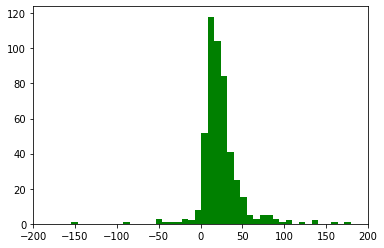

In [322]:
ax = plt.hist(final_df['Price-to-Earnings Ratio'].astype('float'), 200, facecolor='g')
plt.xlim(-200, 200)

## Removing Glamour Stocks

The opposite of a "value stock" is a "glamour stock". 

Since the goal of this strategy is to identify the 50 best value stocks from our universe, our next step is to remove glamour stocks from the DataFrame.

We'll sort the DataFrame by the stocks' price-to-earnings ratio, and drop all stocks outside the top 50.

In [323]:
final_df.sort_values('Price-to-Earnings Ratio', inplace=True)
final_df = final_df[final_df['Price-to-Earnings Ratio'] > 0]
final_df = final_df[0:50]
final_df.reset_index(inplace=True, drop=True)
final_df

,Ticker,Company Name,Price,Price-to-Earnings Ratio,Number of Shares to Buy
0,NRG,NRG Energy Inc.,39.91,2.38,N/A
1,EBAY,EBay Inc.,44.46,2.41,N/A
2,AMZN,Amazon.com Inc.,111.62,2.6,N/A
3,NUE,Nucor Corp.,119.97,4.23,N/A
4,SYF,Synchrony Financial,31.62,4.29,N/A
5,COF,Capital One Financial Corp.,110.46,4.37,N/A
6,F,Ford Motor Co.,12.32,4.44,N/A
7,AIG,American International Group Inc,53.01,4.62,N/A
8,PVH,PVH Corp,64.6,4.74,N/A
9,DHI,D.R. Horton Inc.,65.69,4.75,N/A


## Calculating the Number of Shares to Buy
We now need to calculate the number of shares we need to buy. 

To do this, we will use the `portfolio_input` function that we created in our momentum project.

I have included this function below.

In [324]:
def set_portfolio_size():
    portfolio_input = input('Enter the size of your portfolio:')
    
    try:
        float(portfolio_input)
        return portfolio_input
    except ValueError:
        print('That is not a number...\nPlease Try Again')
        portfolio_input = set_portfolio_size()
        return portfolio_input

Use the `portfolio_input` function to accept a `portfolio_size` variable from the user of this script.

In [325]:
portfolio_size = set_portfolio_size()
print('Portfolio Size:', portfolio_size)

Portfolio Size: 1e6


You can now use the global `portfolio_size` variable to calculate the number of shares that our strategy should purchase.

In [326]:
position_size = float(portfolio_size)/len(final_df.index)
for row in final_df.index:
    final_df.loc[row, 'Number of Shares to Buy'] = math.floor(position_size/final_df['Price'][row])

final_df

,Ticker,Company Name,Price,Price-to-Earnings Ratio,Number of Shares to Buy
0,NRG,NRG Energy Inc.,39.91,2.38,501
1,EBAY,EBay Inc.,44.46,2.41,449
2,AMZN,Amazon.com Inc.,111.62,2.6,179
3,NUE,Nucor Corp.,119.97,4.23,166
4,SYF,Synchrony Financial,31.62,4.29,632
5,COF,Capital One Financial Corp.,110.46,4.37,181
6,F,Ford Motor Co.,12.32,4.44,1623
7,AIG,American International Group Inc,53.01,4.62,377
8,PVH,PVH Corp,64.6,4.74,309
9,DHI,D.R. Horton Inc.,65.69,4.75,304


## Building a Better (and More Realistic) Value Strategy
Every valuation metric has certain flaws.

For example, the price-to-earnings ratio doesn't work well with stocks with negative earnings.

Similarly, stocks that buyback their own shares are difficult to value using the price-to-book ratio.

Investors typically use a `composite` basket of valuation metrics to build robust quantitative value strategies. In this section, we will filter for stocks with the lowest percentiles on the following metrics:

* Price-to-earnings ratio
* Price-to-book ratio
* Price-to-sales ratio
* Enterprise Value divided by Earnings Before Interest, Taxes, Depreciation, and Amortization (EV/EBITDA)
* Enterprise Value divided by Gross Profit (EV/GP)

Some of these metrics aren't provided directly by the IEX Cloud API, and must be computed after pulling raw data. We'll start by calculating each data point from scratch.

In [327]:
symbol = 'AAPL'
batch_api_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={symbol}&types=quote,advanced-stats&token={IEX_CLOUD_API_TOKEN}'

data = requests.get(batch_api_url).json()

price = data[symbol]['quote']['latestPrice']

# Price-to-earnings ratio
pe_ratio = data[symbol]['quote']['peRatio']
# Price-to-book ratio
pb_ratio = data[symbol]['advanced-stats']['priceToBook']
# Price-to-sales ratio
ps_ratio = data[symbol]['advanced-stats']['priceToSales']
# Enterprise Value divided by Earnings Before Interest, Taxes, Depreciation, and Amortization (EV/EBITDA)
ev_ebitda = data[symbol]['advanced-stats']['enterpriseValue'] / data[symbol]['advanced-stats']['EBITDA']
# Enterprise Value divided by Gross Profit (EV/GP)
ev_gp = data[symbol]['advanced-stats']['enterpriseValue'] / data[symbol]['advanced-stats']['grossProfit']

print(f'Price: {price}\nP/E: {pe_ratio}\nP/B: {pb_ratio}\nP/S: {ps_ratio}\nEV/EBITDA: {ev_ebitda}\nEV/GP: {ev_gp}')

Price: 141.53
P/E: 23.09
P/B: 32.78
P/S: 5.79
EV/EBITDA: 16.974091591468603
EV/GP: 13.532974398256084


Let's move on to building our DataFrame. You'll notice that I use the abbreviation `rv` often. It stands for `robust value`, which is what we'll call this sophisticated strategy moving forward.

In [328]:
rv_columns = [
    'Ticker',
    'Company Name',
    'Price',
    'Number of Shares to Buy',
    'P/E',
    'P/E Percentile',
    'P/B',
    'P/B Percentile',
    'P/S',
    'P/S Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score'
]

rv_df = pd.DataFrame(columns=rv_columns)
rv_df

,Ticker,Company Name,Price,Number of Shares to Buy,P/E,P/E Percentile,P/B,P/B Percentile,P/S,P/S Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score


In [329]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]   
        
symbol_groups = list(chunks(stocks_list['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))
    # print(symbol_strings[i])

for symbol_string in symbol_strings:
    batch_api_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=quote,advanced-stats&token={IEX_CLOUD_API_TOKEN}'
    batch_data = requests.get(batch_api_url).json()

    for symbol in symbol_string.split(','):
        if symbol in batch_data:
            company_name = batch_data[symbol]['quote']['companyName']
            price = batch_data[symbol]['quote']['latestPrice']
            pe_ratio = batch_data[symbol]['quote']['peRatio']
            pb_ratio = batch_data[symbol]['advanced-stats']['priceToBook']
            ps_ratio = batch_data[symbol]['advanced-stats']['priceToSales']
            try:
                ev_ebitda = batch_data[symbol]['advanced-stats']['enterpriseValue'] / batch_data[symbol]['advanced-stats']['EBITDA']
            except TypeError:
                ev_ebitda = np.NaN
            try:    
                ev_gp = batch_data[symbol]['advanced-stats']['enterpriseValue'] / batch_data[symbol]['advanced-stats']['grossProfit']
            except TypeError:
                ev_gp = np.NaN

            rv_df = pd.concat([rv_df, pd.DataFrame([[symbol, company_name, price, 'N/A', pe_ratio, 'N/A', pb_ratio, 'N/A', ps_ratio, 'N/A', ev_ebitda, 'N/A', ev_gp, 'N/A', 'N/A']], columns=rv_columns)], ignore_index=True)
            
        else:
            print('Missing Symbol:', symbol)

rv_df.head()

Missing Symbol: DISCA
Missing Symbol: HFC
Missing Symbol: VIAC
Missing Symbol: WLTW


,Ticker,Company Name,Price,Number of Shares to Buy,P/E,P/E Percentile,P/B,P/B Percentile,P/S,P/S Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,A,Agilent Technologies Inc.,120.63,N/A,28.75,N/A,6.94,N/A,5.5,N/A,19.465008,N/A,10.01432,N/A,N/A
1,AAL,American Airlines Group Inc,13.78,N/A,-3.72,N/A,-0.9478,N/A,0.2452,N/A,-20.942135,N/A,0.975075,N/A,N/A
2,AAP,Advance Auto Parts Inc,178.39,N/A,19,N/A,3.6,N/A,0.9599,N/A,11.263912,N/A,2.318594,N/A,N/A
3,AAPL,Apple Inc,140.56,N/A,22.75,N/A,32.34,N/A,5.66,N/A,16.354614,N/A,13.319217,N/A,N/A
4,ABBV,Abbvie Inc,139.27,N/A,20.1,N/A,15.16,N/A,4.46,N/A,10.777572,N/A,7.708875,N/A,N/A


## Dealing With Missing Data in Our DataFrame

Our DataFrame contains some missing data because all of the metrics we require are not available through the API we're using. 

You can use pandas' `isnull` method to identify missing data:

In [330]:
rv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Ticker                   501 non-null    object
 1   Company Name             501 non-null    object
 2   Price                    501 non-null    object
 3   Number of Shares to Buy  501 non-null    object
 4   P/E                      492 non-null    object
 5   P/E Percentile           501 non-null    object
 6   P/B                      482 non-null    object
 7   P/B Percentile           501 non-null    object
 8   P/S                      482 non-null    object
 9   P/S Percentile           501 non-null    object
 10  EV/EBITDA                482 non-null    object
 11  EV/EBITDA Percentile     501 non-null    object
 12  EV/GP                    482 non-null    object
 13  EV/GP Percentile         501 non-null    object
 14  RV Score                 501 non-null    o

In [331]:
rv_df[rv_df.isnull().any(axis=1)]

,Ticker,Company Name,Price,Number of Shares to Buy,P/E,P/E Percentile,P/B,P/B Percentile,P/S,P/S Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
28,ALXN,Alexion Pharmaceuticals Inc.,185.7,N/A,61.84,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
40,AON,Aon plc. - Class A,254.64,N/A,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
71,BRK.B,Berkshire Hathaway Inc. - Class B,286.4,N/A,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
88,CERN,Cerner Corp.,96.54,N/A,49.7,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
118,CTL,"CenturyLink, Inc.",11,N/A,9.79,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
135,DISCK,Warner Bros.Discovery Inc - Series C,24.68,N/A,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
164,ETFC,E*TRADE Financial Corporation,49.81,N/A,14.46,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
185,FLIR,"Flir Systems, Inc.",58.05,N/A,33.35,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
189,FOX,Fox Corporation - Class B,31.29,N/A,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A
192,FRT,Federal Realty Investment Trust.,99.05,N/A,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A


Dealing with missing data is an important topic in data science.

There are two main approaches:

* Drop missing data from the data set (pandas' `dropna` method is useful here)
* Replace missing data with a new value (pandas' `fillna` method is useful here)

In this tutorial, we will replace missing data with the average non-`NaN` data point from that column. 

Here is the code to do this:

In [332]:
for column in rv_columns[4:14:2]:
    print(f'{column}:', rv_df[column].mean())
    rv_df[column].fillna(rv_df[column].mean(), inplace=True)

P/E: 22.62823170731707
P/B: 3.6773724066390017
P/S: 3.6348375518672205
EV/EBITDA: 12.176068362052817
EV/GP: 7.3166571434961005


Now, if we run the statement from earlier to print rows that contain missing data, nothing should be returned:

In [333]:
rv_df[rv_df.isnull().any(axis=1)]

,Ticker,Company Name,Price,Number of Shares to Buy,P/E,P/E Percentile,P/B,P/B Percentile,P/S,P/S Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score


## Calculating Value Percentiles

We now need to calculate value score percentiles for every stock in the universe. More specifically, we need to calculate percentile scores for the following metrics for every stock:

* Price-to-earnings ratio
* Price-to-book ratio
* Price-to-sales ratio
* EV/EBITDA
* EV/GP

Here's how we'll do this:

In [334]:
for row in rv_df.index:
    for column_num in range(4, 14, 2):
        rv_df.loc[row, rv_columns[column_num+1]] = score(rv_df[rv_columns[column_num]], rv_df.loc[row, rv_columns[column_num]]) / 100

In [335]:
rv_df

,Ticker,Company Name,Price,Number of Shares to Buy,P/E,P/E Percentile,P/B,P/B Percentile,P/S,P/S Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,A,Agilent Technologies Inc.,120.63,N/A,28.75,0.720559,6.9400,0.817365,5.5000,0.826347,19.465008,0.784431,10.014320,0.778443,N/A
1,AAL,American Airlines Group Inc,13.78,N/A,-3.72,0.033932,-0.9478,0.05988,0.2452,0.00998,-20.942135,0.007984,0.975075,0.037924,N/A
2,AAP,Advance Auto Parts Inc,178.39,N/A,19.00,0.472056,3.6000,0.553892,0.9599,0.143713,11.263912,0.373253,2.318594,0.141717,N/A
3,AAPL,Apple Inc,140.56,N/A,22.75,0.582834,32.3400,0.968064,5.6600,0.830339,16.354614,0.676647,13.319217,0.888224,N/A
4,ABBV,Abbvie Inc,139.27,N/A,20.10,0.489022,15.1600,0.928144,4.4600,0.744511,10.777572,0.349301,7.708875,0.642715,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,YUM,Yum Brands Inc.,113.5,N/A,20.90,0.51996,-3.8000,0.055888,4.7900,0.775449,19.011694,0.770459,8.692380,0.704591,N/A
497,ZBH,Zimmer Biomet Holdings Inc,110.41,N/A,106.61,0.986028,1.9200,0.296407,2.8900,0.530938,17.575254,0.714571,5.321679,0.393214,N/A
498,ZBRA,Zebra Technologies Corp. - Class A,318.18,N/A,20.77,0.511976,5.6200,0.749501,2.8500,0.522954,15.946886,0.664671,6.643112,0.510978,N/A
499,ZION,Zions Bancorporation N.A,54.82,N/A,5.49,0.075848,1.3900,0.176647,2.3400,0.437126,4.200787,0.061876,2.095096,0.129741,N/A


## Calculating the RV Score
We'll now calculate our RV Score (which stands for Robust Value), which is the value score that we'll use to filter for stocks in this investing strategy.

The RV Score will be the arithmetic mean of the 4 percentile scores that we calculated in the last section.

To calculate arithmetic mean, we will use the mean function from Python's built-in statistics module.

In [336]:
from statistics import mean

for row in rv_df.index:
    ratio_percentiles = []
    for column in rv_columns[5:14:2]:
        ratio_percentiles.append(rv_df[column][row])
    rv_df.loc[row, 'RV Score'] = mean(ratio_percentiles)

## Selecting the 50 Best Value Stocks¶

As before, we can identify the 50 best value stocks in our universe by sorting the DataFrame on the RV Score column and dropping all but the top 50 entries.

In [337]:
rv_df.sort_values('RV Score', inplace=True)
rv_df = rv_df[0:50]
rv_df.reset_index(inplace=True, drop=True)
rv_df

,Ticker,Company Name,Price,Number of Shares to Buy,P/E,P/E Percentile,P/B,P/B Percentile,P/S,P/S Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,AAL,American Airlines Group Inc,13.78,N/A,-3.72,0.033932,-0.9478,0.05988,0.2452,0.00998,-20.942135,0.007984,0.975075,0.037924,0.02994
1,AIG,American International Group Inc,52.9,N/A,4.56,0.05988,0.7489,0.075848,0.7808,0.117764,2.673055,0.027944,0.739363,0.017964,0.05988
2,GPS,"Gap, Inc.",9.21,N/A,-49.75,0.00998,1.4200,0.185629,0.2113,0.007984,4.790190,0.087824,0.700833,0.013972,0.061078
3,GM,General Motors Company,35.04,N/A,5.96,0.091816,0.7819,0.081836,0.3770,0.027944,1.910662,0.01996,1.560795,0.085828,0.061477
4,UNM,Unum Group,33.65,N/A,7.67,0.117764,0.6690,0.071856,0.5933,0.06986,3.716701,0.043912,0.553284,0.007984,0.062275
5,LNC,Lincoln National Corp.,49.86,N/A,7.24,0.107784,0.5775,0.065868,0.4420,0.041916,5.201075,0.101796,0.426264,0.001996,0.063872
6,PVH,PVH Corp,64.5,N/A,4.68,0.061876,0.7965,0.083832,0.4534,0.045908,4.685402,0.083832,1.050935,0.047904,0.064671
7,PRU,Prudential Financial Inc.,95.37,N/A,7.87,0.123752,0.8211,0.085828,0.5505,0.063872,4.738250,0.085828,0.520689,0.005988,0.073054
8,F,Ford Motor Co.,12.76,N/A,4.29,0.053892,1.0900,0.12475,0.3610,0.021956,3.892546,0.051896,1.970770,0.113772,0.073253
9,SYF,Synchrony Financial,31.56,N/A,4.13,0.051896,1.2100,0.141717,0.8932,0.131737,2.562914,0.023952,0.956800,0.031936,0.076248


## Calculating the Number of Shares to Buy
We'll use the `portfolio_input` function that we created earlier to accept our portfolio size. Then we will use similar logic in a for loop to calculate the number of shares to buy for each stock in our investment universe.

In [338]:
portfolio_size = set_portfolio_size()
print('Portfolio Size:', portfolio_size)

Portfolio Size: 1e6


In [339]:
position_size = float(portfolio_size)/len(rv_df.index)

for row in rv_df.index:
    rv_df.loc[row, 'Number of Shares to Buy'] = math.floor(position_size/rv_df['Price'][row])

In [340]:
rv_df.head()

,Ticker,Company Name,Price,Number of Shares to Buy,P/E,P/E Percentile,P/B,P/B Percentile,P/S,P/S Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,AAL,American Airlines Group Inc,13.78,1451,-3.72,0.033932,-0.9478,0.05988,0.2452,0.00998,-20.942135,0.007984,0.975075,0.037924,0.02994
1,AIG,American International Group Inc,52.9,378,4.56,0.05988,0.7489,0.075848,0.7808,0.117764,2.673055,0.027944,0.739363,0.017964,0.05988
2,GPS,"Gap, Inc.",9.21,2171,-49.75,0.00998,1.4200,0.185629,0.2113,0.007984,4.790190,0.087824,0.700833,0.013972,0.061078
3,GM,General Motors Company,35.04,570,5.96,0.091816,0.7819,0.081836,0.3770,0.027944,1.910662,0.01996,1.560795,0.085828,0.061477
4,UNM,Unum Group,33.65,594,7.67,0.117764,0.6690,0.071856,0.5933,0.06986,3.716701,0.043912,0.553284,0.007984,0.062275


## Formatting Our Excel Output

We will be using the XlsxWriter library for Python to create nicely-formatted Excel files.

XlsxWriter is an excellent package and offers tons of customization. However, the tradeoff for this is that the library can seem very complicated to new users. Accordingly, this section will be fairly long because I want to do a good job of explaining how XlsxWriter works.

In [341]:
writer = pd.ExcelWriter('value_recommended_trades.xlsx', engine='xlsxwriter')

rv_df.to_excel(writer, sheet_name='Value Strategy', index=False)

## Creating the Formats We'll Need For Our .xlsx File
You'll recall from our first project that formats include colors, fonts, and also symbols like % and $. We'll need four main formats for our Excel document:

* String format for tickers
* \$XX.XX format for stock prices
* \$XX,XXX format for market capitalization
* Integer format for the number of shares to purchase
* Float formats with 1 decimal for each valuation metric

Since we already built some formats in past sections of this course, I've included them below for you. Run this code cell before proceeding.

In [342]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

float_template = writer.book.add_format(
        {
            'num_format':'0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [343]:
rv_df_columns = rv_df.columns
rv_df_columns

Index(['Ticker', 'Company Name', 'Price', 'Number of Shares to Buy', 'P/E',
       'P/E Percentile', 'P/B', 'P/B Percentile', 'P/S', 'P/S Percentile',
       'EV/EBITDA', 'EV/EBITDA Percentile', 'EV/GP', 'EV/GP Percentile',
       'RV Score'],
      dtype='object')

In [344]:
column_formats = {
    'A': [rv_df_columns[0], string_template],
    'B': [rv_df_columns[1], string_template],
    'C': [rv_df_columns[2], dollar_template],
    'D': [rv_df_columns[3], integer_template],
    'E': [rv_df_columns[4], float_template],
    'F': [rv_df_columns[5], percent_template],
    'G': [rv_df_columns[6], float_template],
    'H': [rv_df_columns[7], percent_template],
    'I': [rv_df_columns[8], float_template],
    'J': [rv_df_columns[9], percent_template],
    'K': [rv_df_columns[10], float_template],
    'L': [rv_df_columns[11], percent_template],
    'M': [rv_df_columns[12], float_template],
    'N': [rv_df_columns[13], percent_template],
    'O': [rv_df_columns[14], float_template]
}

for column in column_formats.keys():
    writer.sheets['Value Strategy'].set_column(f'{column}:{column}', 25, column_formats[column][1])
    writer.sheets['Value Strategy'].write(f'{column}1', column_formats[column][0], string_template)

## Saving Our Excel Output
As before, saving our Excel output is very easy:

In [345]:
writer.save()